<h1 style="color: #001a79;">Topic 4 - Machine Learning Project Notebook</h1>

In [2]:
# Efficient numerical arrays.
import numpy as np

# Dataframes for data manipulation and analysis.
import pandas as pd

# Neural networks.
import tensorflow.keras as keras

# Plotting.
import matplotlib.pyplot as plt

import seaborn as sns

import matplotlib.dates as mdates

<h3 style="color: #001a79;">Introduction</h3>

<hr style="border-top: 1px solid #001a79;" />

Comeback to

https://keras.io/examples/timeseries/timeseries_anomaly_detection/

<h3 style="color: #001a79;">Numenta Anomaly Benchmark (NAB) Dataset</h3>

<hr style="border-top: 1px solid #001a79;" />

- The Numenta Anomaly Benchmark (NAB) is a novel benchmark for evaluating algorithms for anomaly detection in streaming, online applications. 
- It is comprised of over 50 labeled real-world and artificial timeseries data files. 
- Plus a novel scoring mechanism designed for real-time applications.
- All of the data and code is fully open-source, with extensive documentation, and a scoreboard of anomaly detection algorithms found <a href="https://github.com/numenta/NAB" target="_blank">here</a>. 

Source: <a href="https://www.kaggle.com/datasets/boltzmannbrain/nab" target="_blank">Kaggle: Numenta Anomaly Benchmark (NAB) Dataset</a>

<h3 style="color: #001a79;">Loading the Data</h3>

<hr style="border-top: 1px solid #001a79;" />

To demonstrate anomaly detection effectively we will use two datasets from the Numenta Anomaly Benchmark (NAB) Dataset. 

1. <a href="https://github.com/numenta/NAB/blob/master/data/artificialNoAnomaly/art_daily_small_noise.csv" target="_blank">`art_daily_small_noise.csv`</a> file for training.
2. <a href="https://github.com/numenta/NAB/blob/master/data/artificialWithAnomaly/art_daily_jumpsup.csv" target="_blank">`the art_daily_jumpsup.csv`</a> file for testing.

### `df_small_noise`

In [3]:
# These CSVs can be found at the follow URL.
root_url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/'

In [4]:
# art_daily_small_noise.csv data file url.
no_anomaly_url = root_url + 'artificialNoAnomaly/art_daily_small_noise.csv'

In [5]:
# Import and save data as a df - df_small_noise. 
# parse_dates=True will tell pandas you are importing a date while index_col="timestamp" sets timestamp as the index. 
df_small_noise = pd.read_csv(no_anomaly_url, parse_dates=True, index_col="timestamp")

# Print 
df_small_noise

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120
...,...
2014-04-14 23:35:00,20.211195
2014-04-14 23:40:00,20.531041
2014-04-14 23:45:00,19.032127


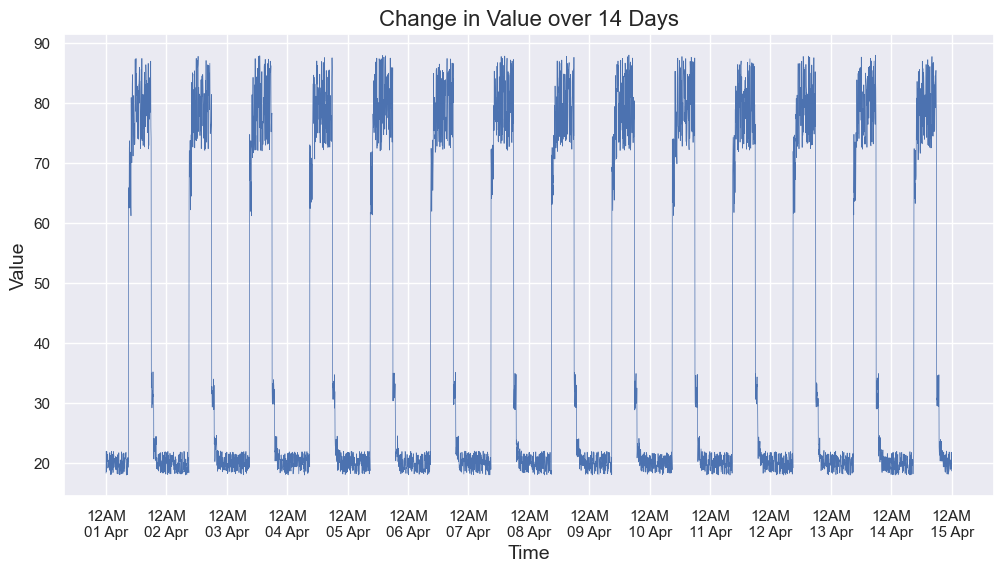

In [35]:
# Graph style
sns.set(style="darkgrid")

# Set figure size
fig, ax = plt.subplots(figsize=(12,6))

# Add title
plt.title("Change in Value over 14 Days", fontsize=16)

# Add x and y labels
plt.xlabel('Time', fontsize=14)
plt.ylabel('Value', fontsize=14)

# Define the date format
date_form = mdates.DateFormatter("12AM\n%d %b")
ax.xaxis.set_major_formatter(date_form)

# Set x-axis to 1 day intervals
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))

# Plot Time vs Value
plt.plot(df_small_noise.index, df_small_noise['value'], linewidth=0.5);

https://www.earthdatascience.org/courses/use-data-open-source-python/use-time-series-data-in-python/date-time-types-in-pandas-python/customize-dates-matplotlib-plots-python/#:~:text=Using%20the%20DateFormatter%20module%20from,number%20with%20lower%20case%20m
https://matplotlib.org/stable/api/dates_api.html
https://www.youtube.com/watch?v=_LWjaAiKaf8&t=889s&ab_channel=CoreySchafer

`df_small_noise` contains 4,032 rows of data with 2 columns `timestamp` (the index) and `value`. 

`timestamp` - Is the dataframes index and represents a **date and time** formatted as Year-Month-Day (YYYY-MM-DD) and Hours:Minutes:Seconds (hh:mm:ss). 

The timestamp starts at the 1st of April 2014 at 12:00am and increments by 5 minutes at each row. The last data point on 14th of April 2014 at 12:55pm. 

Therefore for 14 days, every 5 minutes a value is recorded. 
- Every hour 12 values are recorded. 
- Every day 288 values are recorded. 
- So in 14 days 4,032 values are recorded in total.

`value` - 

### `df_daily_jumpsup` 

In [37]:
# art_daily_jumpsup.csv data file url.
with_anomaly_url = root_url + 'artificialWithAnomaly/art_daily_jumpsup.csv'

# Import and save data as a df - df_daily_jumpsup. 
df_daily_jumpsup  = pd.read_csv(with_anomaly_url, parse_dates=True, index_col="timestamp")

# Print 
df_daily_jumpsup

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739
...,...
2014-04-14 23:35:00,18.074649
2014-04-14 23:40:00,21.002014
2014-04-14 23:45:00,20.566713


`df_daily_jumpsup` also contains 4,032 rows of data with 2 columns `timestamp` (the index) and `value`. 

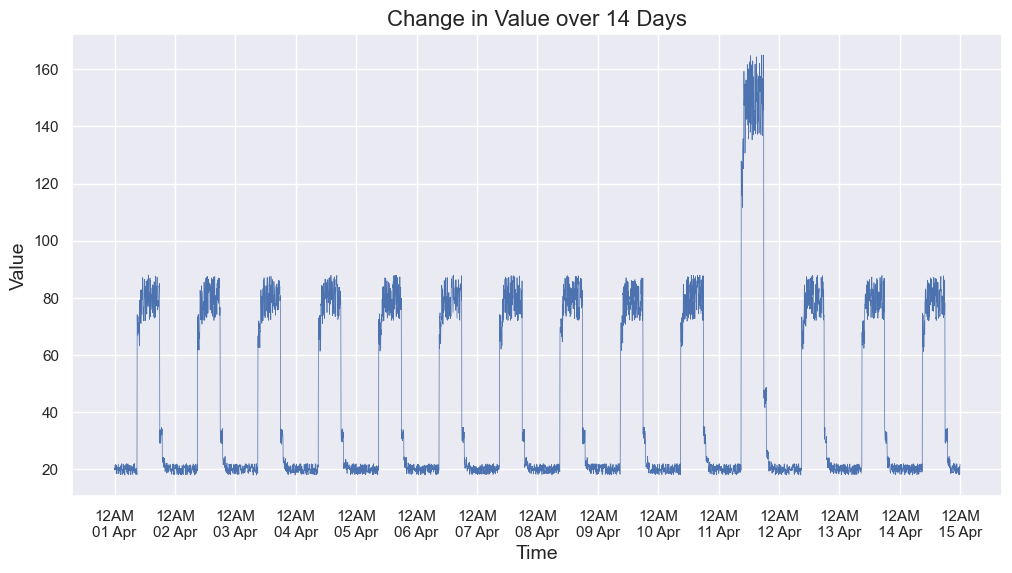

In [38]:
# Graph style
sns.set(style="darkgrid")

# Set figure size
fig, ax = plt.subplots(figsize=(12,6))

# Add title
plt.title("Change in Value over 14 Days", fontsize=16)

# Add x and y labels
plt.xlabel('Time', fontsize=14)
plt.ylabel('Value', fontsize=14)

# Define the date format
date_form = mdates.DateFormatter("12AM\n%d %b")
ax.xaxis.set_major_formatter(date_form)

# Set x-axis to 1 day intervals
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))

# Plot Time vs Value
plt.plot(df_daily_jumpsup.index, df_daily_jumpsup['value'], linewidth=0.5);